In [1]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim

## Data

In [ ]:
# hand-crafted graph

h = [
    (0,1,1),(1,2,1),(2,3,1),(3,0,1),
    (0,4,1),
    (4,5,1),(4,6,1)
]

H = nx.Graph()
for src, dst, wt in h:
    H.add_edge(src, dst, weight=wt)

nodes = list(H.nodes)
num_nodes = len(nodes)

# triples: shortest paths between pairs of nodes as (origin, destination, shortest distance)
triples = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        try:
            orig = nodes[i]
            dest = nodes[j]
            dist = nx.shortest_path_length(H, orig, dest, weight='weight')
            triples.append((orig, dest, dist))
        except Exception:
            pass

pairs = [[orig, dest] for orig, dest, _ in triples]
pairs = torch.tensor(pairs)

graph_distance =[dist for _,_,dist in triples]
graph_distance = torch.tensor(graph_distance)

In [ ]:
# grid
# (5,5,5,5) has 625 nodes

H = nx.grid_graph(dim=(5,5,5,5))
H = nx.convert_node_labels_to_integers(H, ordering="sorted")

nodes = list(H.nodes)
num_nodes = len(nodes)

triples = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        try:
            a = nodes[i]
            b = nodes[j]
            dist = nx.shortest_path_length(H, a, b, weight='weight')
            triples.append((a, b, dist))
        except Exception:
            pass

pairs = [[a, b] for a, b, _ in triples]
pairs = torch.tensor(pairs)

graph_distance =[d for _,_,d in triples]
graph_distance = torch.tensor(graph_distance)

In [3]:
# tree
# depth 5 & branching factor 3 has 364 nodes

H = nx.balanced_tree(3,5)

nodes = list(H.nodes)
num_nodes = len(nodes)

triples = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        try:
            a = nodes[i]
            b = nodes[j]
            dist = nx.shortest_path_length(H, a, b, weight='weight')
            triples.append((a, b, dist))
        except Exception:
            pass

pairs = [[a, b] for a, b, _ in triples]
pairs = torch.tensor(pairs)

graph_distance =[d for _,_,d in triples]
graph_distance = torch.tensor(graph_distance)

In [ ]:
# zach karate
H = nx.karate_club_graph()

nodes = list(H.nodes)
num_nodes = len(nodes)

triples = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        try:
            a = nodes[i]
            b = nodes[j]
            dist = nx.shortest_path_length(H, a, b, weight='weight')
            triples.append((a, b, dist))
        except Exception:
            pass

pairs = [[a, b] for a, b, _ in triples]
pairs = torch.tensor(pairs)

graph_distance =[d for _,_,d in triples]
graph_distance = torch.tensor(graph_distance)

In [ ]:
nx.draw(H, with_labels=True, pos=nx.spring_layout(H))

## Model Definition

In [4]:
def distortion(graph_distances, manifold_distances):
    loss = torch.pow(torch.div(manifold_distances, graph_distances), 2)
    loss = torch.abs(loss - 1)
    loss = loss.sum()
    return loss

In [5]:
class EuclideanPlane:
    def __init__(self):
        pass

    def distance(self, x, y):
        d = torch.sum(torch.abs(x - y), dim=1)
        return d

In [6]:
class Embedding(nn.Module):
    def __init__(self, number_points, dim=2):
        super().__init__()
        # naive initialization
        self._embedding = torch.nn.parameter.Parameter(data=torch.rand([number_points, dim])-0.5)

    def forward(self, node_index):
        return self._embedding[node_index]

In [7]:
class Model(nn.Module):
    def __init__(self, number_points, dim=2):
        super().__init__()
        self.manifold = EuclideanPlane()
        self.embedding = Embedding(number_points, dim=dim)

    def forward(self, node_index_pairs):
        nodes1_indices, nodes2_indices = node_index_pairs[:,0], node_index_pairs[:,1]
        nodes1_embeddings = self.embedding(nodes1_indices)
        nodes2_embeddings = self.embedding(nodes2_indices)
        return self.manifold.distance(nodes1_embeddings, nodes2_embeddings)

## Evaluation Metrics

In [8]:
def average_distortion(graph_distances, manifold_distances):
    distortion = torch.abs(manifold_distances - graph_distances) / graph_distances
    avg = torch.mean(distortion)
    return avg

## Training the Model

In [9]:
torch.autograd.set_detect_anomaly(True)

In [10]:
model = Model(num_nodes, dim=4)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=250, verbose=True)

In [11]:
for epoch in range(5000):
    optimizer.zero_grad()
    manifold_dist = model(pairs)
    loss = distortion(graph_distance, manifold_dist)
    scheduler.step(loss)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        #print(epoch, loss.item())
        print(
            "Epoch: {}.\tLoss: {:.5f}.\tAvg. Distortion: {:.5f}.".format(
                epoch, loss.item(), average_distortion(graph_distance, manifold_dist)
            )
        )

Epoch: 0.	Loss: 63391.91797.	Avg. Distortion: 0.81982.
Epoch: 100.	Loss: 21725.56250.	Avg. Distortion: 0.19048.
Epoch: 200.	Loss: 22065.59570.	Avg. Distortion: 0.19323.
Epoch: 300.	Loss: 22766.38086.	Avg. Distortion: 0.20168.
Epoch: 400.	Loss: 22316.23047.	Avg. Distortion: 0.19780.
Epoch: 500.	Loss: 23147.02344.	Avg. Distortion: 0.20489.
Epoch: 600.	Loss: 22159.10156.	Avg. Distortion: 0.19486.
Epoch: 700.	Loss: 22294.41016.	Avg. Distortion: 0.19559.
Epoch: 800.	Loss: 22790.72461.	Avg. Distortion: 0.20126.
Epoch   833: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 900.	Loss: 9221.89258.	Avg. Distortion: 0.09530.
Epoch: 1000.	Loss: 9286.65039.	Avg. Distortion: 0.09591.
Epoch: 1100.	Loss: 9102.97559.	Avg. Distortion: 0.09470.
Epoch: 1200.	Loss: 9109.28320.	Avg. Distortion: 0.09484.
Epoch: 1300.	Loss: 9139.65625.	Avg. Distortion: 0.09522.
Epoch: 1400.	Loss: 9068.71973.	Avg. Distortion: 0.09469.
Epoch: 1500.	Loss: 9055.77832.	Avg. Distortion: 0.09465.
Epoch: 1600.	Loss: 9124.15820

## Model Inspection

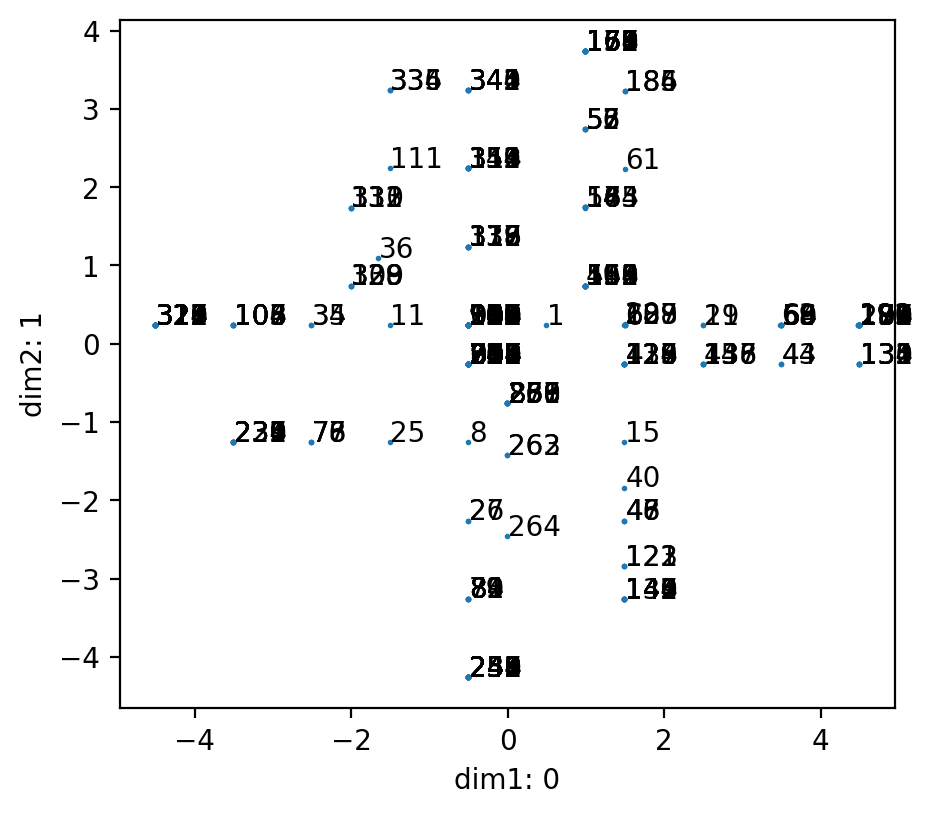

In [12]:
dim1 = 0
dim2 = 1

x = model.embedding._embedding[:,dim1].detach().numpy()
y = model.embedding._embedding[:,dim2].detach().numpy()

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(x, y, s=1)
plt.xlabel('dim1: {}'.format(dim1))
plt.ylabel('dim2: {}'.format(dim2))

ax = plt.gca()
for i, txt in enumerate(nodes):
    ax.annotate(txt, (x[i] + 0.01, y[i] + 0.01))

ax.set_aspect(1)

In [13]:
# edge, manifold dist, vector
for edge in H.edges:
    vvd = (model.embedding._embedding[edge[0]]-model.embedding._embedding[edge[1]]).detach().numpy()
    print(edge, np.sum(np.abs(vvd)), np.round(vvd, 3))

(0, 1) 1.0001285 [-1. -0. -0. -0.]
(0, 2) 1.001402 [0.001 0.499 0.001 0.501]
(0, 3) 1.0000434 [ 0.001 -0.    -0.499 -0.501]
(1, 4) 1.9996115 [-0.998  0.5    0.001 -0.5  ]
(1, 5) 1.000022 [-0.498 -0.5    0.001 -0.   ]
(1, 6) 1.9968904 [-0.999 -0.    -0.498  0.499]
(2, 7) 1.0001801 [ 0.    -0.     0.999  0.001]
(2, 8) 0.99990386 [ 0.  1. -0. -0.]
(2, 9) 1.0015534 [-0.001  0.001 -0.001  0.999]
(3, 10) 1.0000564 [ 0.  0. -0. -1.]
(3, 11) 1.0000532 [ 1. -0.  0.  0.]
(3, 12) 0.9999915 [ 0. -0. -1.  0.]
(4, 13) 1.0011944 [-0.001  0.001  0.001 -0.999]
(4, 14) 1.0000812 [-1.  0.  0. -0.]
(4, 15) 1.0000625 [-0.  1.  0. -0.]
(5, 16) 1.0000427 [ 0. -0.  1.  0.]
(5, 17) 0.9999899 [-0. -1.  0. -0.]
(5, 18) 0.9999869 [-0. -1. -0. -0.]
(6, 19) 1.000033 [-1.  0.  0.  0.]
(6, 20) 1.000571 [-0.001 -0.018 -0.981  0.   ]
(6, 21) 1.0000236 [-1.  0.  0. -0.]
(7, 22) 1.0000426 [-0.  0.  1.  0.]
(7, 23) 1.000073 [-0.  0.  1.  0.]
(7, 24) 1.0000619 [-0.  0.  0.  1.]
(8, 25) 1.0000249 [1. 0. 0. 0.]
(8, 26) 1.000

(96, 291) 1.0000339 [-0. -0.  0. -1.]
(97, 292) 1.0000236 [-0. -0.  0. -1.]
(97, 293) 1.0000137 [-0. -0.  0. -1.]
(97, 294) 1.0000141 [-0. -0.  0. -1.]
(98, 295) 1.0000365 [ 0. -0. -1. -0.]
(98, 296) 1.0000365 [ 0. -0. -1. -0.]
(98, 297) 1.0000345 [ 0. -0. -1. -0.]
(99, 298) 1.000009 [-0.  0. -0. -1.]
(99, 299) 1.000008 [-0.  0. -0. -1.]
(99, 300) 1.000004 [-0. -0. -0. -1.]
(100, 301) 1.0000504 [-0.  0.  0. -1.]
(100, 302) 1.0000515 [-0.  0.  0. -1.]
(100, 303) 1.0000474 [-0.  0.  0. -1.]
(101, 304) 1.0000476 [-0. -0.  0. -1.]
(101, 305) 1.0000471 [-0. -0.  0. -1.]
(101, 306) 1.0000435 [-0. -0.  0. -1.]
(102, 307) 1.0000427 [-0.  0. -0. -1.]
(102, 308) 1.0000356 [-0. -0. -0. -1.]
(102, 309) 1.0000393 [-0. -0. -0. -1.]
(103, 310) 1.0000209 [ 1. -0. -0. -0.]
(103, 311) 1.0000156 [ 1. -0. -0. -0.]
(103, 312) 1.0000179 [ 1. -0. -0.  0.]
(104, 313) 1.0000122 [ 1.  0. -0.  0.]
(104, 314) 1.000008 [ 1.  0. -0. -0.]
(104, 315) 1.0000112 [ 1.  0. -0.  0.]
(105, 316) 1.0000218 [ 1. -0. -0.  0.]


In [ ]:
# connected node pair, graph distance, embedding distance, vector
# for i, pair in enumerate(pairs):
#     print(
#         pair.detach().numpy(),
#         graph_distance[i].item(),
#         round(model(pair.reshape(1, -1)).item(), 3),
#         (model.embedding._embedding[pair[0]]-model.embedding._embedding[pair[1]]).detach().numpy().round(3)
# )